In [1]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(3, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

if __name__ == "__main__":
    input_shape = (256, 256, 3)
    model = build_unet(input_shape)
    model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalization[0][0

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Define image dimensions
input_shape = (256, 256)
num_classes = 2

In [3]:
train_dir = '/content/drive/MyDrive/dataset2/dataset2/train'
valid_dir='/content/drive/MyDrive/dataset2/dataset2/valid'
test_dir = '/content/drive/MyDrive/dataset2/dataset2/test'

In [4]:
# Data Augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

In [5]:
# No augmentation for validation and test data, just rescale
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [6]:
# Generator for loading and augmenting training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape,
    batch_size=16,
    class_mode='input',  # Make sure to set class_mode to 'input'
    color_mode='rgb'  # Make sure to set color_mode to 'rgb' to load RGB images
)

# Generator for loading validation data
valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=input_shape,
    batch_size=16,
    class_mode='input',  # Make sure to set class_mode to 'input'
    color_mode='rgb'  # Make sure to set color_mode to 'rgb' to load RGB images
)

# Generator for loading test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape,
    batch_size=16,
    class_mode='input',  # Make sure to set class_mode to 'input'
    color_mode='rgb'  # Make sure to set color_mode to 'rgb' to load RGB images
)


Found 1798 images belonging to 2 classes.
Found 495 images belonging to 2 classes.
Found 441 images belonging to 2 classes.


In [7]:
# Compile the model
model = build_unet((*input_shape, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
# Train the model
history = model.fit(train_generator,steps_per_epoch = 5,validation_steps = 5, epochs=10, validation_data=valid_generator)

Epoch 1/10
5/5 [==============================] - 792s 165s/step - loss: 0.6494 - accuracy: 0.5094 - val_loss: 0.6686 - val_accuracy: 0.8778
Epoch 2/10
5/5 [==============================] - 753s 161s/step - loss: 0.6034 - accuracy: 0.7802 - val_loss: 3.0225 - val_accuracy: 0.7525
Epoch 3/10
5/5 [==============================] - 692s 146s/step - loss: 0.5982 - accuracy: 0.8650 - val_loss: 7.5282 - val_accuracy: 0.8286
Epoch 4/10
5/5 [==============================] - 736s 157s/step - loss: 0.5852 - accuracy: 0.9224 - val_loss: 6.8814 - val_accuracy: 0.8304
Epoch 5/10
5/5 [==============================] - 733s 156s/step - loss: 0.5987 - accuracy: 0.9207 - val_loss: 2.0220 - val_accuracy: 0.7880
Epoch 6/10
5/5 [==============================] - 723s 154s/step - loss: 0.5829 - accuracy: 0.9153 - val_loss: 0.9907 - val_accuracy: 0.8594
Epoch 7/10
5/5 [==============================] - 724s 154s/step - loss: 0.5813 - accuracy: 0.9186 - val_loss: 0.6822 - val_accuracy: 0.8719
Epoch 8/10
5/

In [9]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(valid_generator)
test_loss, test_accuracy = model.evaluate(test_generator)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


28/28 [==============================] - 814s 29s/step - loss: 0.6666 - accuracy: 0.8952
Validation Loss: 0.6527209877967834
Validation Accuracy: 0.8491309285163879
Test Loss: 0.6666197776794434
Test Accuracy: 0.8951653242111206


ModuleNotFoundError: No module named 'matplotlib.plot'

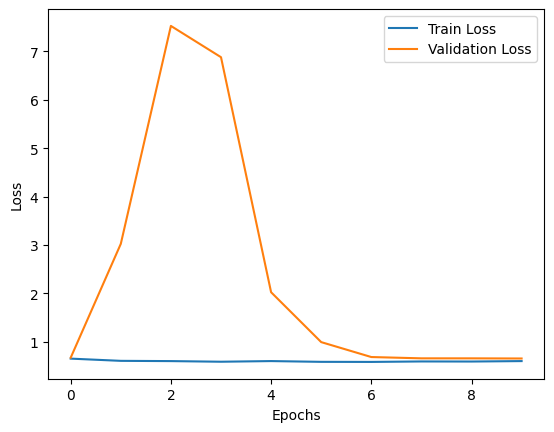

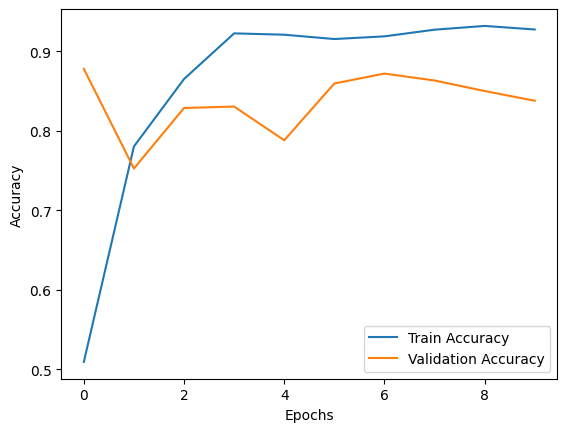

In [13]:
import matplotlib.pyplot as plt
# Plot loss and accuracy
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
# Assuming you have trained the model using the code snippet provided
# You can access the final training and validation accuracy from the history object

# Get the final training and validation accuracy
final_training_accuracy = history.history['accuracy'][-1]
final_validation_accuracy = history.history['val_accuracy'][-1]

# Print the final training and validation accuracy
print("Final Training Accuracy:", final_training_accuracy)
print("Final Validation Accuracy:", final_validation_accuracy)


Final Training Accuracy: 0.9272691607475281
Final Validation Accuracy: 0.8377151489257812


In [38]:
import numpy as np

unique_values_true = np.unique(y_true)
unique_values_pred = np.unique(y_pred)

print("Unique values in y_true:", unique_values_true)
print("Unique values in y_pred:", unique_values_pred)


Unique values in y_true: [0 1]
Unique values in y_pred: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232